The objective of this notebook is to apply the algos on ```ADMMAMA.py```. We will use the following __sintetic__ dataset: 

In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from ADMMAMA import ADMMfullyconected, ADMMgeneral, AMA, built_edges

In [2]:
X_or = np.array([
    [1,1],
    [1,2],
    [2,1],
    [2,2]
])

X_ref = -X_or

X = np.vstack((X_or, X_ref))

We will use two weights matrices:

- fully conected but $$w_{ij} = \frac{1}{d_{ij}^2}$$ with $d_{ij}= ||x_i - x_j||_2$  

- Not fully conected: $$w_{ij} = l_{\{i,j\}}^{k}  \exp(- \phi d_{ij})$$ with $l_{\{i,j\}}^{k}$ es $1$ si $x_j$ esta entre los $k$ vecinos más cercanos de $x_i$. We set the coalescence $\phi$ to $\frac{1}{2}$ 

In [3]:
def fully_connected_w(X):

    D = cdist(X,X, 'euclidean')

    with np.errstate(divide='ignore'):
        W = 1 / np.square(D)
    np.fill_diagonal(W, 0)
    
    return W


def knn_w(X, k=3, phi=0.5):

    D = cdist(X,X, 'euclidean')
    np.fill_diagonal(D, np.inf)

    n = D.shape[0]
    W = np.zeros((n,n))

    for i in range(n): #Recorremos cada punto
        idx = np.argsort(D[i,:]) #Indices de los k vecinos más cercanos
        for j in idx[0:k]:  # skip the first one since it's the point itself
            W[i,j] = np.exp(-phi * D[i,j])

    W = np.maximum(W, W.T)  # Hacer la matriz simétrica
    
    return W

In [4]:
W_conn = fully_connected_w(X)
W_knn = knn_w(X, k=3, phi=0.5)

In [5]:
def plot_graph_weights(X, W, title):
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(X[:,0], X[:,1], c='steelblue', s=80, zorder=3)
    
    nonzero_W = W[W > 0]
    vmin, vmax = np.min(nonzero_W), np.max(nonzero_W)
    
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            if W[i,j] > 0:
                plt.plot(
                    [X[i,0], X[j,0]],
                    [X[i,1], X[j,1]],
                    color=plt.cm.plasma((W[i,j]-vmin)/(vmax-vmin)),
                    linewidth=2.5 * (W[i,j]/vmax),
                    alpha=0.9
                )
    
    # Etiquetas de nodos
    for i, (x, y) in enumerate(X):
        plt.text(x+0.05, y+0.05, f"{i}", fontsize=11, color="black")

    sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = plt.colorbar(sm, ax = ax)
    cbar.set_label('Edge Weights', rotation=270, labelpad=15)

    ax.set_title(title)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.show()


Visualitiations:

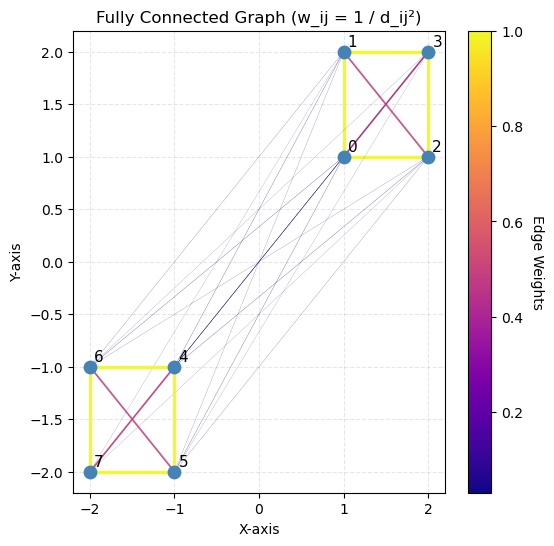

In [6]:
plot_graph_weights(X, W_conn, "Fully Connected Graph (w_ij = 1 / d_ij²)")

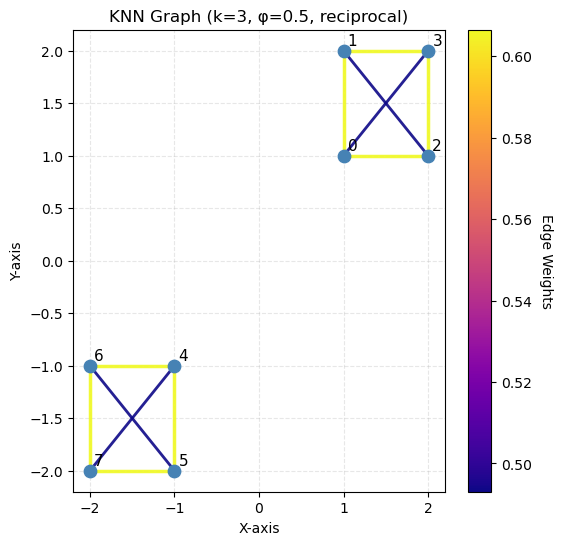

In [7]:
plot_graph_weights(X, W_knn,  "KNN Graph (k=3, φ=0.5, reciprocal)")

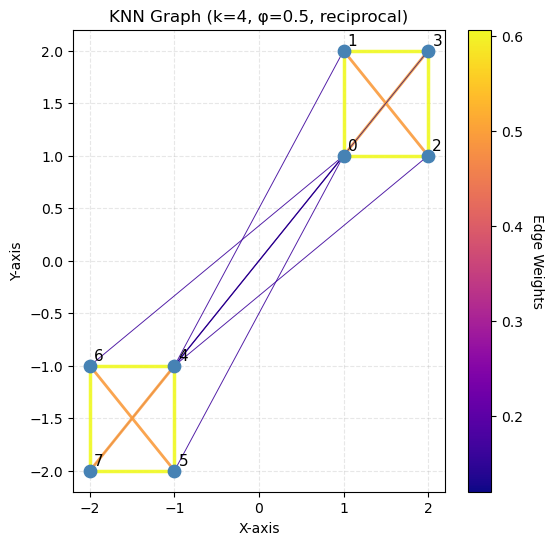

In [8]:
W_knn_4 = knn_w(X, k=4, phi=0.5)
plot_graph_weights(X, W_knn_4,  "KNN Graph (k=4, φ=0.5, reciprocal)")

We see that the knn method gives more relevance to the clusters while the connected method puts more relevance on the geometry of the data (?).

Now we will apply the algos:

In [9]:
W_conn

array([[0.        , 1.        , 1.        , 0.5       , 0.125     ,
        0.07692308, 0.07692308, 0.05555556],
       [1.        , 0.        , 0.5       , 1.        , 0.07692308,
        0.05      , 0.05555556, 0.04      ],
       [1.        , 0.5       , 0.        , 1.        , 0.07692308,
        0.05555556, 0.05      , 0.04      ],
       [0.5       , 1.        , 1.        , 0.        , 0.05555556,
        0.04      , 0.04      , 0.03125   ],
       [0.125     , 0.07692308, 0.07692308, 0.05555556, 0.        ,
        1.        , 1.        , 0.5       ],
       [0.07692308, 0.05      , 0.05555556, 0.04      , 1.        ,
        0.        , 0.5       , 1.        ],
       [0.07692308, 0.05555556, 0.05      , 0.04      , 1.        ,
        0.5       , 0.        , 1.        ],
       [0.05555556, 0.04      , 0.04      , 0.03125   , 0.5       ,
        1.        , 1.        , 0.        ]])

In [10]:
X = X.astype(float)

U_ADMM, V_ADMM, lambda_ADMM, history  = ADMMfullyconected(X, gamma= 10, W=W_conn,
                                                          nu = 8, max_iter= 1000, tol =0,
                                                          norm_type='L2',verbose=True)

it    1 | primal_res 6.536e-02 | obj 2.062284
it   50 | primal_res 9.488e-11 | obj 2.390533
it  100 | primal_res 0.000e+00 | obj 2.390533
it  150 | primal_res 0.000e+00 | obj 2.390533
it  200 | primal_res 0.000e+00 | obj 2.390533
it  250 | primal_res 0.000e+00 | obj 2.390533
it  300 | primal_res 0.000e+00 | obj 2.390533
it  350 | primal_res 0.000e+00 | obj 2.390533
it  400 | primal_res 0.000e+00 | obj 2.390533
it  450 | primal_res 0.000e+00 | obj 2.390533
it  500 | primal_res 0.000e+00 | obj 2.390533
it  550 | primal_res 0.000e+00 | obj 2.390533
it  600 | primal_res 0.000e+00 | obj 2.390533
it  650 | primal_res 0.000e+00 | obj 2.390533
it  700 | primal_res 0.000e+00 | obj 2.390533
it  750 | primal_res 0.000e+00 | obj 2.390533
it  800 | primal_res 0.000e+00 | obj 2.390533
it  850 | primal_res 0.000e+00 | obj 2.390533
it  900 | primal_res 0.000e+00 | obj 2.390533
it  950 | primal_res 0.000e+00 | obj 2.390533
it 1000 | primal_res 0.000e+00 | obj 2.390533


In [11]:
U_ADMM

array([[ 1.        ,  1.        ],
       [ 1.46153846,  1.53846154],
       [ 1.53846154,  1.46153846],
       [ 2.        ,  2.        ],
       [-1.        , -1.        ],
       [-1.46153846, -1.53846154],
       [-1.53846154, -1.46153846],
       [-2.        , -2.        ]])

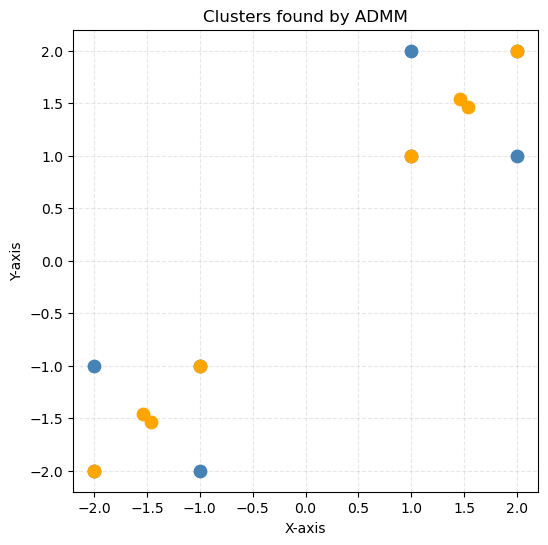

In [12]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[:,0], X[:,1], c='steelblue', s=80, zorder=3)
ax.scatter(U_ADMM[:,0], U_ADMM[:,1], c='orange', s=80, zorder=3)

ax.set_title("Clusters found by ADMM")
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [13]:
U_ADMM_2, V_ADMM, lambda_ADMM, history  = ADMMfullyconected(X, gamma= 10, W=W_knn,
                                                          nu = 8, max_iter= 1000, tol =0,
                                                          norm_type='L2',verbose=True)

it    1 | primal_res 5.073e-02 | obj 1.599379
it   50 | primal_res 0.000e+00 | obj 1.487725
it  100 | primal_res 0.000e+00 | obj 1.487725
it  150 | primal_res 0.000e+00 | obj 1.487725
it  200 | primal_res 0.000e+00 | obj 1.487725
it  250 | primal_res 0.000e+00 | obj 1.487725
it  300 | primal_res 0.000e+00 | obj 1.487725
it  350 | primal_res 0.000e+00 | obj 1.487725
it  400 | primal_res 0.000e+00 | obj 1.487725
it  450 | primal_res 0.000e+00 | obj 1.487725
it  500 | primal_res 0.000e+00 | obj 1.487725
it  550 | primal_res 0.000e+00 | obj 1.487725
it  600 | primal_res 0.000e+00 | obj 1.487725
it  650 | primal_res 0.000e+00 | obj 1.487725
it  700 | primal_res 0.000e+00 | obj 1.487725
it  750 | primal_res 0.000e+00 | obj 1.487725
it  800 | primal_res 0.000e+00 | obj 1.487725
it  850 | primal_res 0.000e+00 | obj 1.487725
it  900 | primal_res 0.000e+00 | obj 1.487725
it  950 | primal_res 0.000e+00 | obj 1.487725
it 1000 | primal_res 0.000e+00 | obj 1.487725


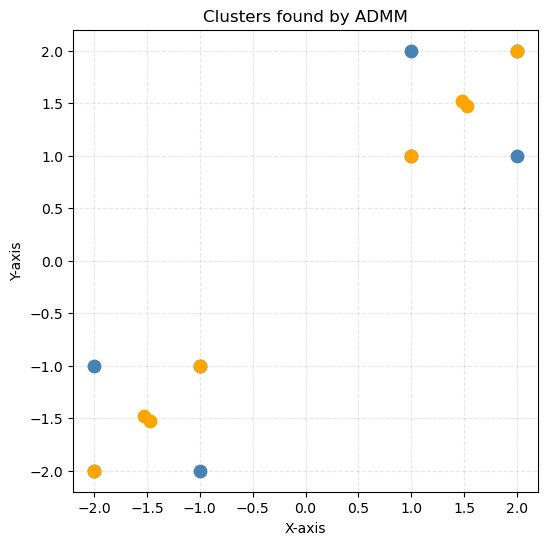

In [14]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[:,0], X[:,1], c='steelblue', s=80, zorder=3)
ax.scatter(U_ADMM_2[:,0], U_ADMM_2[:,1], c='orange', s=80, zorder=3)

ax.set_title("Clusters found by ADMM")
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [18]:
edges = built_edges(W_knn)


In [19]:
edges

([(0, 1),
  (0, 2),
  (0, 3),
  (1, 2),
  (1, 3),
  (2, 3),
  (4, 5),
  (4, 6),
  (4, 7),
  (5, 6),
  (5, 7),
  (6, 7)],
 array([0.60653066, 0.60653066, 0.49306869, 0.49306869, 0.60653066,
        0.60653066, 0.60653066, 0.60653066, 0.49306869, 0.49306869,
        0.60653066, 0.60653066]))

In [21]:
weights

[0.6065306597126334,
 0.6065306597126334,
 0.4930686913952398,
 0.4930686913952398,
 0.6065306597126334,
 0.6065306597126334,
 0.6065306597126334,
 0.6065306597126334,
 0.4930686913952398,
 0.4930686913952398,
 0.6065306597126334,
 0.6065306597126334]

In [23]:
edges = built_edges(W_knn)

weights = [W_knn[i,j] for (i,j) in edges[0]]


U, V, lambda_ = ADMMgeneral(X, edges[0], edges[1], gamma = 10, nu=8,
                max_iter=1000, tol=1e-5,
                norm_type='L2', verbose=False)

ValueError: row index exceeds matrix dimensions